# Data Set 2
Notebook for data set 2, US energy data. On the website I don't see any hourly data. So perhaps the best we can do is predict average monthly targets (load, price etc). Data is sourced from the [U.S. Energy Information Administration](https://www.eia.gov).

In [37]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf

# Set the default color cycle
mpl.style.use('seaborn-v0_8-notebook')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color='bgrcmyk')

Create a dictionary containing the actual human words of the ridiculous mnemonic series names used by EIA.

In [ ]:
# msn = {'CLETPUS':, 'PAETPUS':, 'NGETPUS':, 'OJETPUS':, 
#        'NUETPUS':, 'HPETPUS':, 'HVETPUS':, 'WDETPUS':, 
#        'WSETPUS':, 'GEETPUS':, 'SOETPUS':, 'WYETPUS':,
#        'ELETPUS':}

First data set: Table 7.2a of [eia.gov](https://www.eia.gov/totalenergy/data/monthly/index.php). This is supposed to be the monthly total (net) electricity generation. If I understand it correctly, _net_ implies that imports and exports have been factored in. 

In [2]:
data = pd.read_csv("../data/dat_set_2/MER_T07_02A.csv")
data = data.drop(['Description','Unit'], axis=1)

In [3]:
print(data.columns)

Index(['MSN', 'YYYYMM', 'Value', 'Column_Order'], dtype='object')


In [4]:
data.head(3)

,MSN,YYYYMM,Value,Column_Order
0,CLETPUS,194913,135451.32,1
1,CLETPUS,195013,154519.994,1
2,CLETPUS,195113,185203.657,1


In [5]:
data['MSN'].unique()

array(['CLETPUS', 'PAETPUS', 'NGETPUS', 'OJETPUS', 'NUETPUS', 'HPETPUS',
       'HVETPUS', 'WDETPUS', 'WSETPUS', 'GEETPUS', 'SOETPUS', 'WYETPUS',
       'ELETPUS'], dtype=object)

In [6]:
## some values are "Not Available" --> Set them to zero.
indices = data['Value'].astype(str).str.contains('Not Available')
data['Value'].loc[indices] = '0'
data['Value'].loc[indices]

2040    0
2041    0
2042    0
2043    0
2044    0
       ..
7629    0
7630    0
7631    0
7632    0
7633    0
Name: Value, Length: 830, dtype: object

In [7]:
data = data[~data['YYYYMM'].astype(str).str.match("....13")]
data['time'] = pd.to_datetime(data['YYYYMM'], utc=True, format="%Y%m")

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7878 entries, 24 to 8839
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   MSN           7878 non-null   object             
 1   YYYYMM        7878 non-null   int64              
 2   Value         7878 non-null   object             
 3   Column_Order  7878 non-null   int64              
 4   time          7878 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(2), object(2)
memory usage: 369.3+ KB


In [9]:
data_n = data.convert_dtypes()

In [10]:
data_n.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7878 entries, 24 to 8839
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   MSN           7878 non-null   string             
 1   YYYYMM        7878 non-null   Int64              
 2   Value         7878 non-null   string             
 3   Column_Order  7878 non-null   Int64              
 4   time          7878 non-null   datetime64[ns, UTC]
dtypes: Int64(2), datetime64[ns, UTC](1), string(2)
memory usage: 384.7 KB


In [11]:
data_n['val'] = data_n['Value'].astype(np.float64)

Place a cutoff on the data. For now, start the series on 2000-01-01. 

In [16]:
cutoff_date = pd.Timestamp(tz='UTC', year=1999, month=12, day=1)
data_n = data_n[data_n['time'] > cutoff_date ]
data_n = data_n.set_index('time')

In [17]:
dfs = data_n.groupby("MSN")
print(f"there are {len(dfs)} classes on MSN")
for msn, df in dfs:
    print(f'There are {df.shape[0]} observations in df about MSN: {msn}.')

there are 13 classes on MSN
There are 282 observations in df about MSN: CLETPUS.
There are 282 observations in df about MSN: ELETPUS.
There are 282 observations in df about MSN: GEETPUS.
There are 282 observations in df about MSN: HPETPUS.
There are 282 observations in df about MSN: HVETPUS.
There are 282 observations in df about MSN: NGETPUS.
There are 282 observations in df about MSN: NUETPUS.
There are 282 observations in df about MSN: OJETPUS.
There are 282 observations in df about MSN: PAETPUS.
There are 282 observations in df about MSN: SOETPUS.
There are 282 observations in df about MSN: WDETPUS.
There are 282 observations in df about MSN: WSETPUS.
There are 282 observations in df about MSN: WYETPUS.


Make a plot of the data:

(-5000.0, 480000.0)

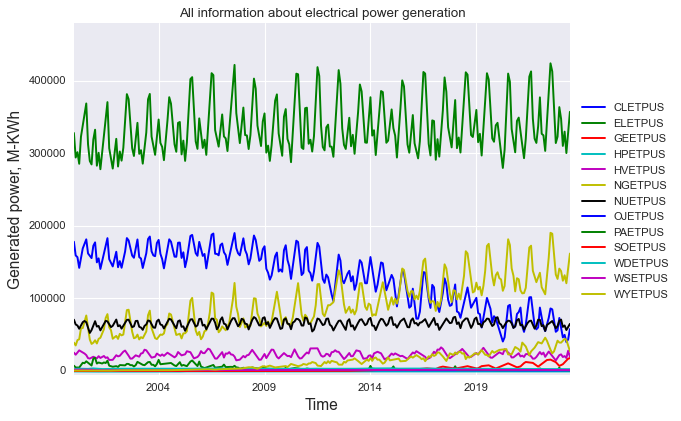

In [82]:
fig, ax = plt.subplots(1,1)
ax.set_title('All information about electrical power generation')
for label, df in dfs:
    df.plot(ax=ax, y='val', label=label)
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Generated power, M-KWh', fontsize=14)
ax.legend(bbox_to_anchor=(1.22,0.8))
ax.set_ylim(bottom=-5000, top=480000)

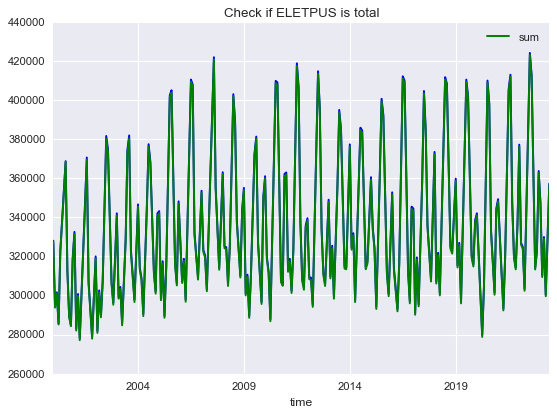

In [84]:
fig, ax = plt.subplots(1,1)
total = np.zeros_like(dfs.get_group('ELETPUS')['val'].values)
ax.set_title("Check if ELETPUS is total")
for label, df in dfs:
    if label != 'ELETPUS':
        total += df['val'].values
df = dfs.get_group('ELETPUS')['val']
ax = df.plot(ax=ax,y='val', label='ELETPUS')
fdta = pd.DataFrame(index=df.index, data={'val':total})
ax = fdta.plot(ax=ax,y='val', label='sum')

I think I can safely conclude that *ELETPUS* is the total electricity generated. Now let's bring in the electricty price data set.

In [ ]:
price_data = pd.read_csv("../data/dat_set_2/